In [4]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
Al_path = "/home/haue/repositories/Masters/data/bananas/Al"
P_path = "/home/haue/repositories/Masters/data/bananas/P"
Si_path = "/home/haue/repositories/Masters/data/bananas/Si"
Mg_path = "/home/haue/repositories/Masters/data/bananas/Mg"
outputdir = "/figure_output/"
cuts ="/home/haue/repositories/Masters/data/cuts/idcuts.root"

In [6]:
#### Loading in data
Al_files = glob.glob(os.path.join(Al_path, "*mlio.root"))
P_files = glob.glob(os.path.join(P_path, "*mlio.root"))
Si_files = glob.glob(os.path.join(Si_path, "*mlio.root"))
Mg_files = glob.glob(os.path.join(Mg_path, "*mlio.root"))
#all_files = Al_files+P_files+Si_files+Mg_files

In [7]:
# Storing the data in a dictionary for easy access

###
# Note to better structure:
# i should load it in like data_collection["detector"]["isotope"]["treeentry"]
# or maybe better data_collection["isotope"]["detector"]["treeentry"] 
# instead of data_collection["isotope"]["treeentry"][detector id]
###

data_files = {
    "Al": Al_files,
    "P": P_files,
    "Mg": Mg_files,
    "Si": Si_files
}
data_collection = {
      "Al": {},
    "P": {},
    "Mg": {},
    "Si": {},
    "All": {}
}



for isotope, files in data_files.items():
    
    
    #initializes a dictionary entry for each isotope and gives it the name specified in the datafiles dictionary
    # each entry, eg. "E", contains 4 lists specifying the 4 id's of the telescopes in rising order
    data_collection[isotope] = {key: [[] for _ in range(4)] for key in
                                ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]}
    
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files))
    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            data_collection[isotope]["E"][i].extend(Es[mask])
            data_collection[isotope]["fEdep"][i].extend(fEdeps[mask])
            data_collection[isotope]["bEdep"][i].extend(bEdeps[mask])
            data_collection[isotope]["angle"][i].extend(angles[mask])
            data_collection[isotope]["Edep"][i].extend(Edeps[mask])
            data_collection[isotope]["FI"][i].extend(FIs[mask])
            data_collection[isotope]["BI"][i].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")
    

tqdm.write("Combining all isotopes into 'All'...")      
## Create the "All" branch in data_collection
data_collection["All"] = {
    ## sum concatenates lists 
    key: [sum((data_collection[isotope][key][i] for isotope in data_files), []) for i in range(4)]
    for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]
}
tqdm.write("✅ All data combined successfully!")


Processing Al:   0%|          | 0/56 [00:00<?, ?file/s]

Processing Si: 100%|██████████| 11/11 [00:33<00:00,  3.07s/file, Completed=10/11]


Combining all isotopes into 'All'...
✅ All data combined successfully!


In [8]:
# Loading in cut values for regions of interest
idcuts = uproot.open(cuts)

x0, y0 = idcuts["id0cut"].values()
x1, y1 = idcuts["id1cut"].values()
x2, y2 = idcuts["id2cut"].values()
xs = [x0/1e3, x1/1e3, x2/1e3]
ys = [y0/1e3, y1/1e3, y2/1e3]



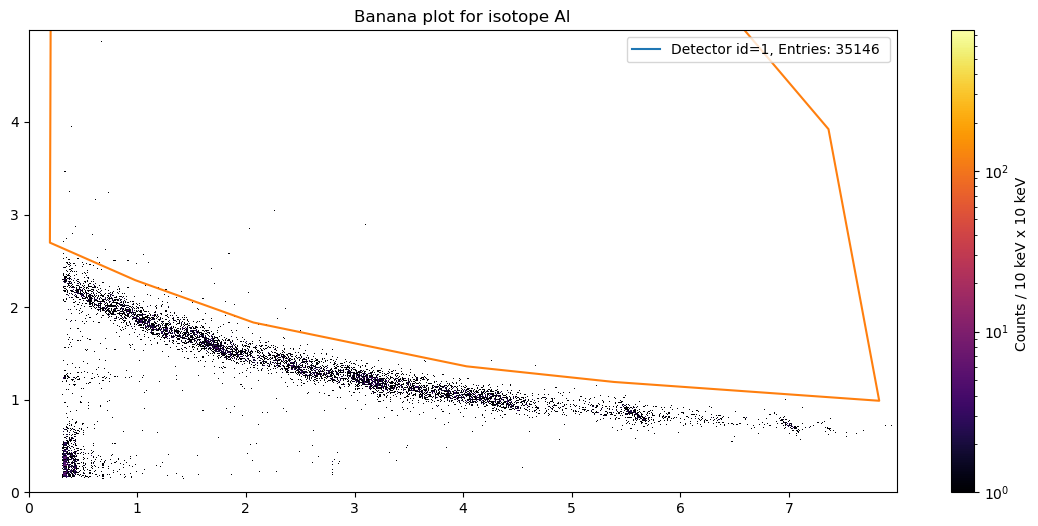

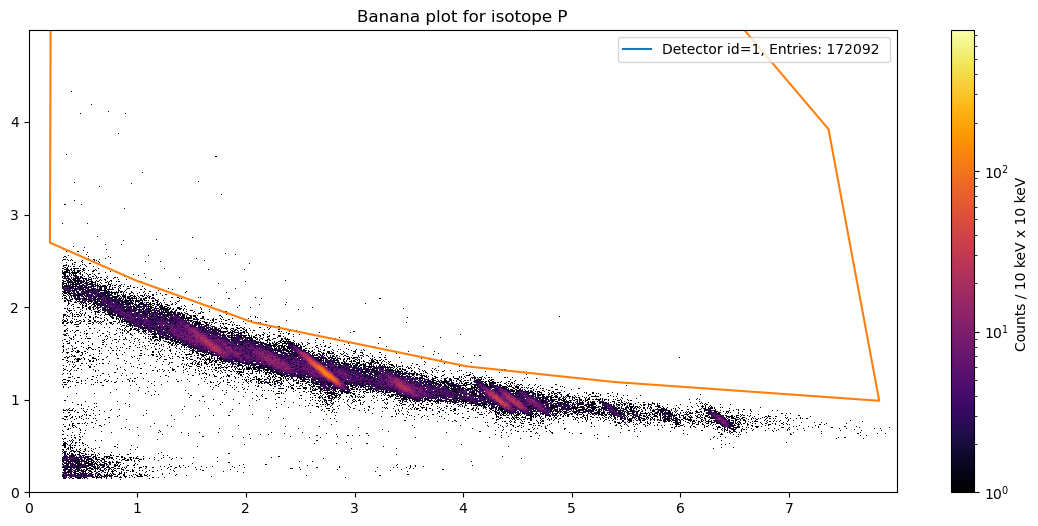

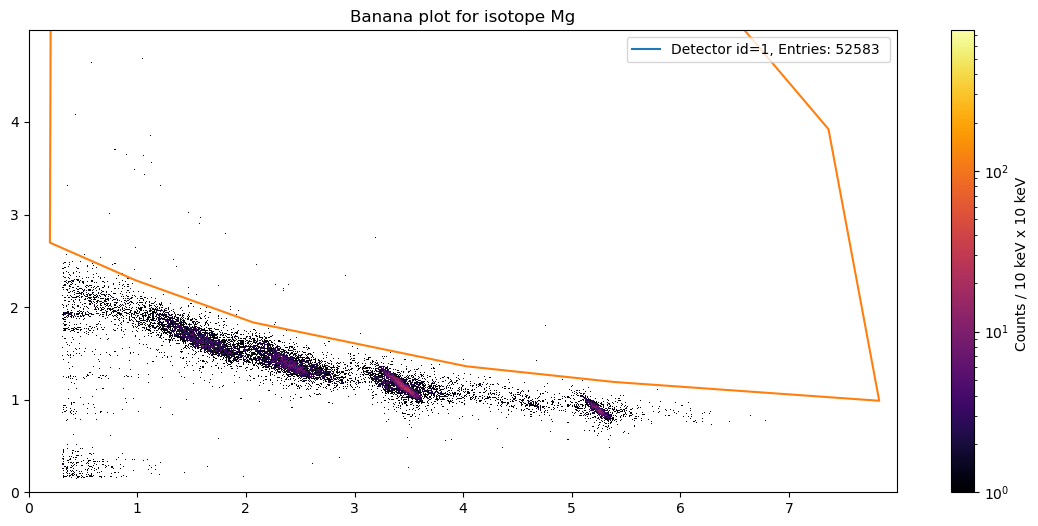

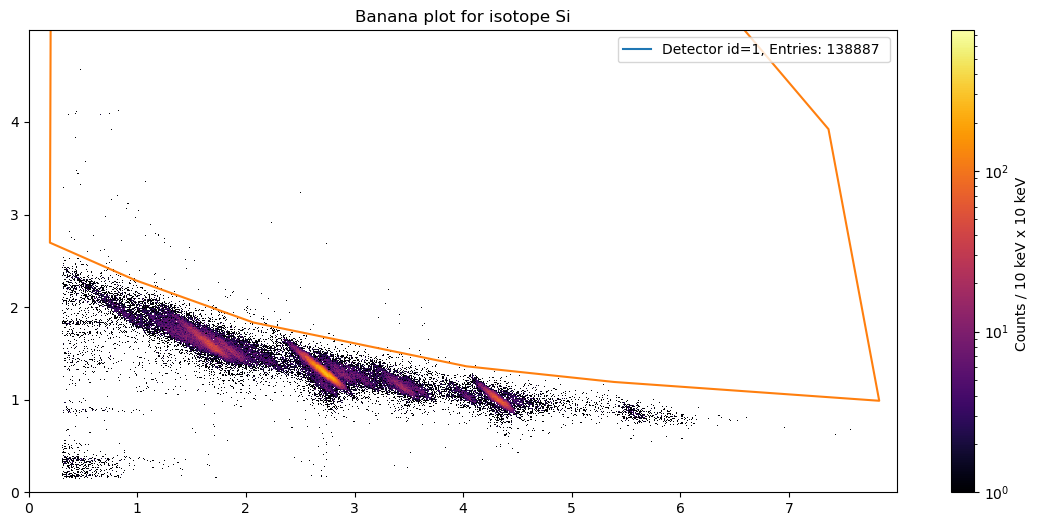

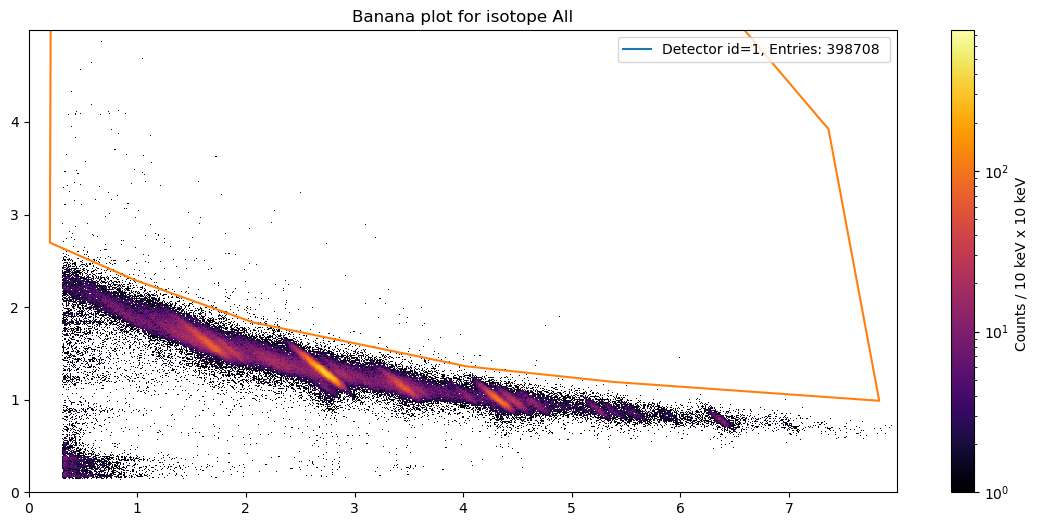

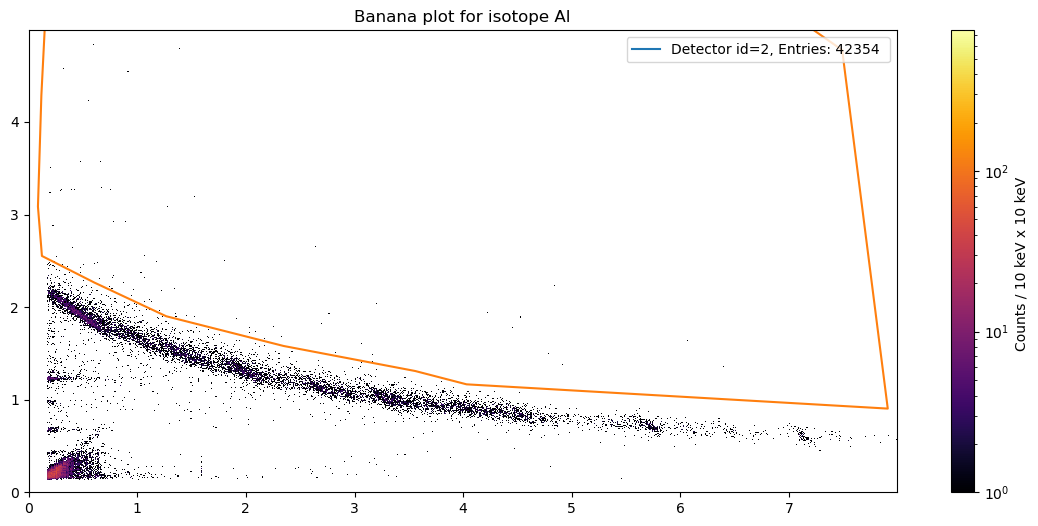

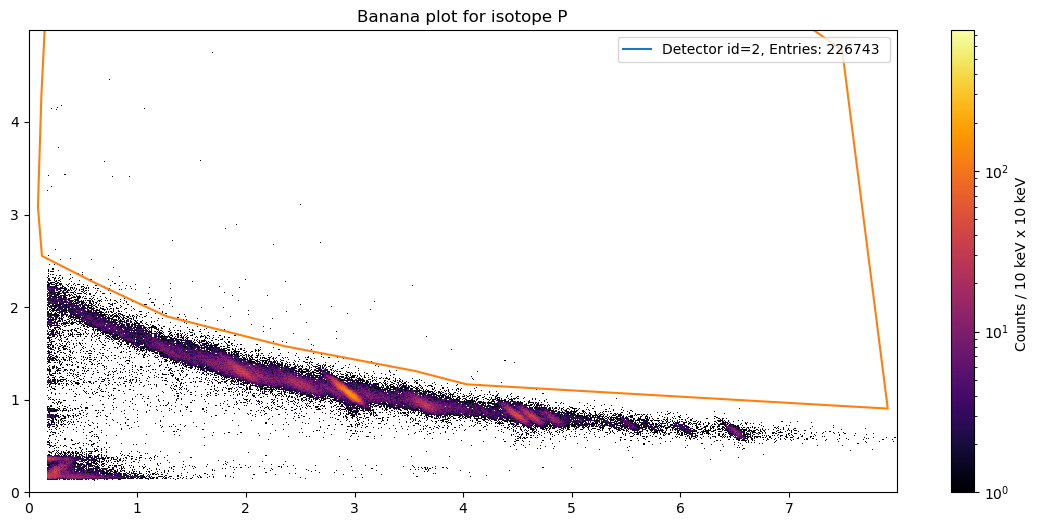

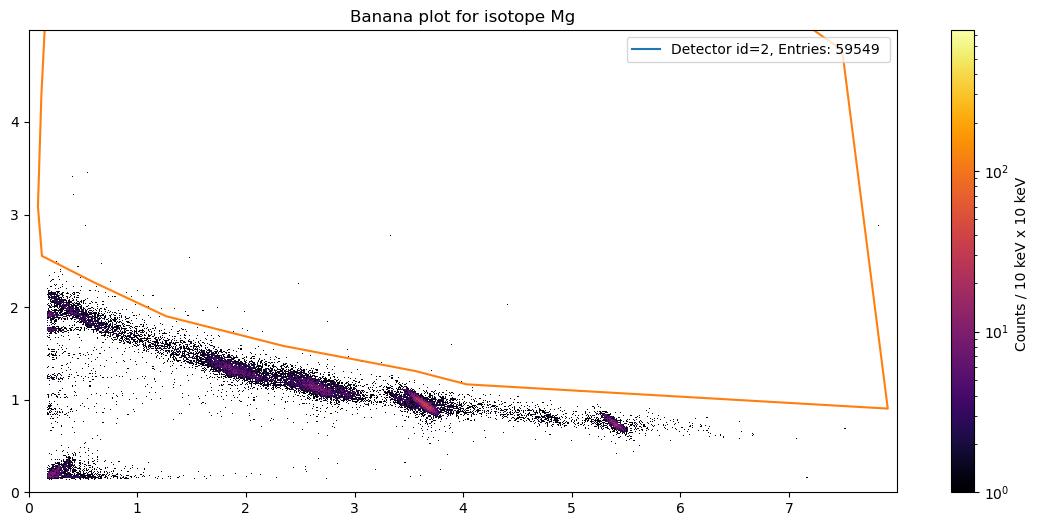

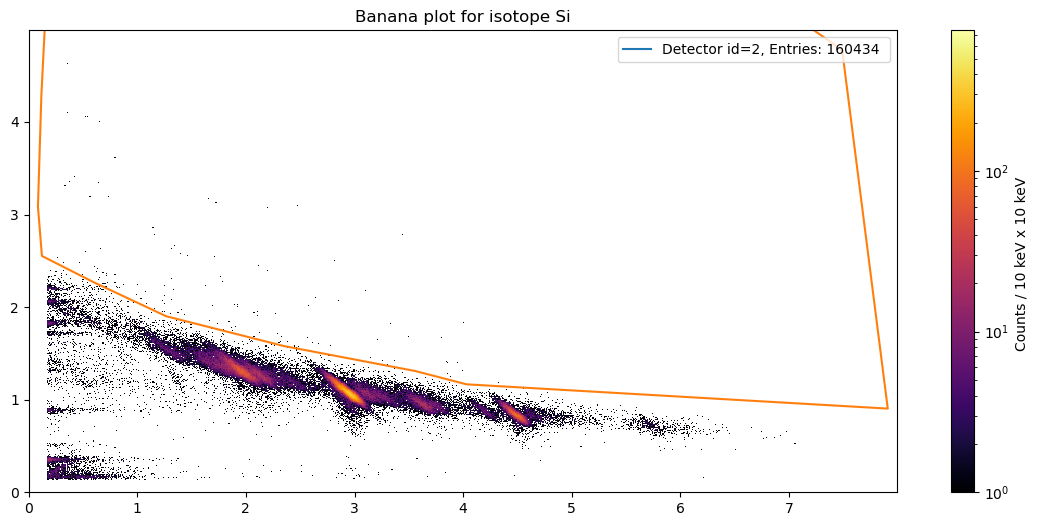

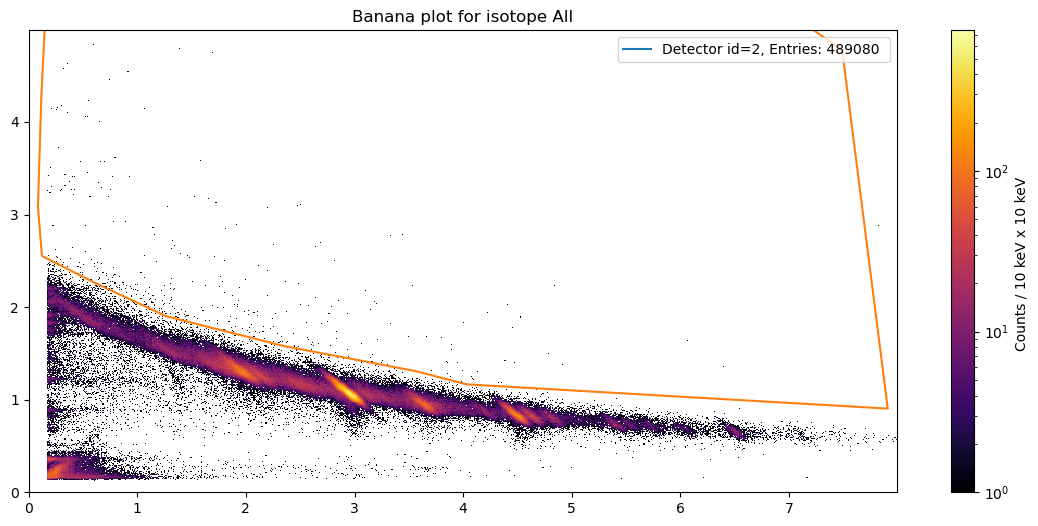

In [9]:
for i in range(1,3):  
    for data in data_collection:
        plt.figure(figsize=(14,6))
        plt.hist2d(data_collection[data]["bEdep"][i], data_collection[data]["fEdep"][i], bins=(np.arange(0, 8, 0.01), np.arange(0, 5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
        plt.title(f"Banana plot for isotope {data}")
        length = len(data_collection[data]["bEdep"][i])
        plt.plot([], [], label=f"Detector id={i}, Entries: {length} ")
        plt.plot(xs[i], ys[i])
        plt.legend(loc='upper right')
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

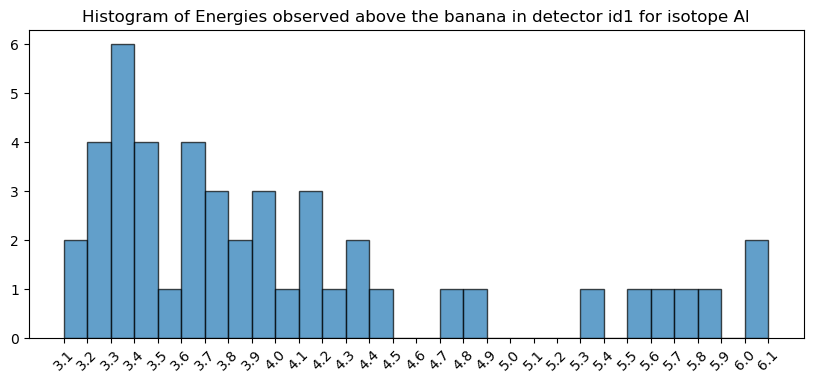

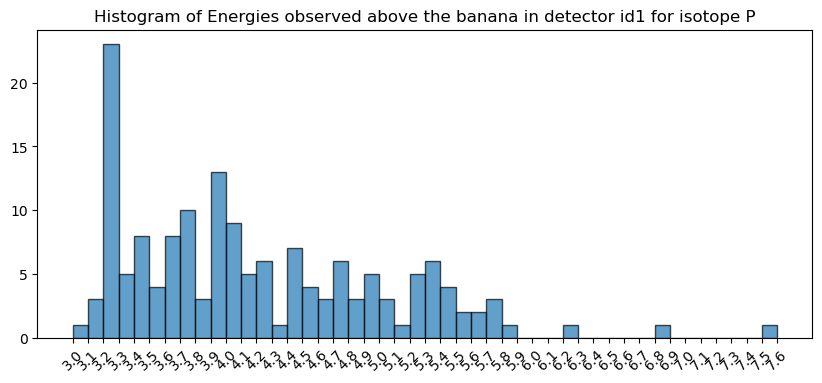

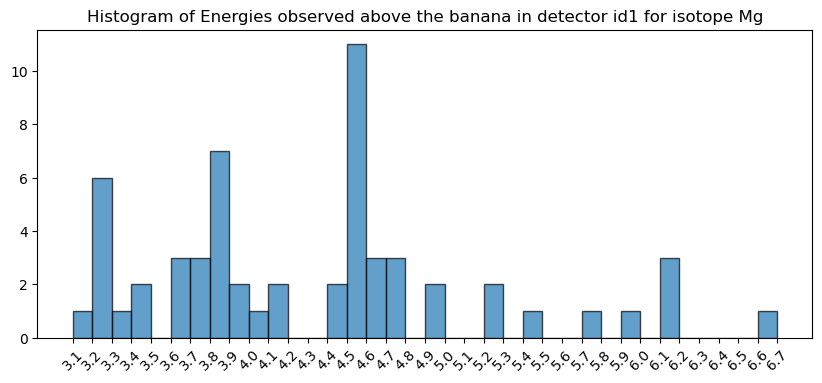

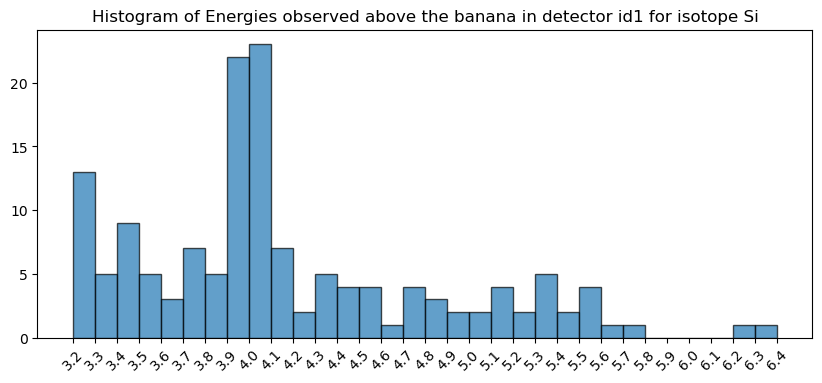

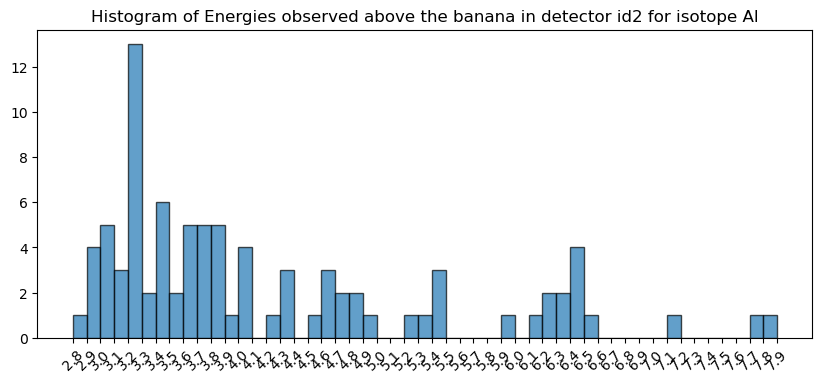

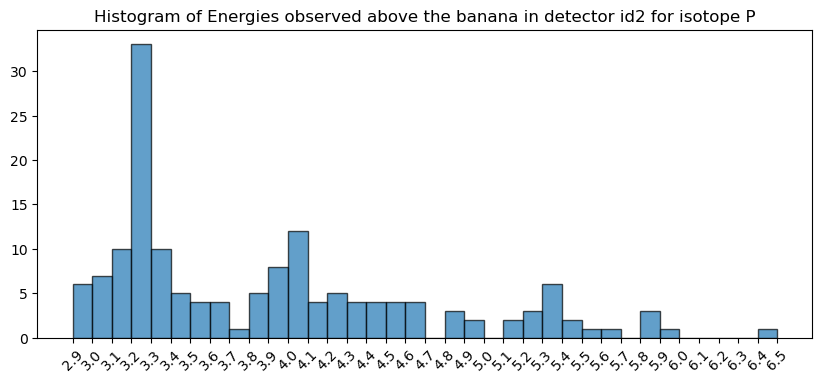

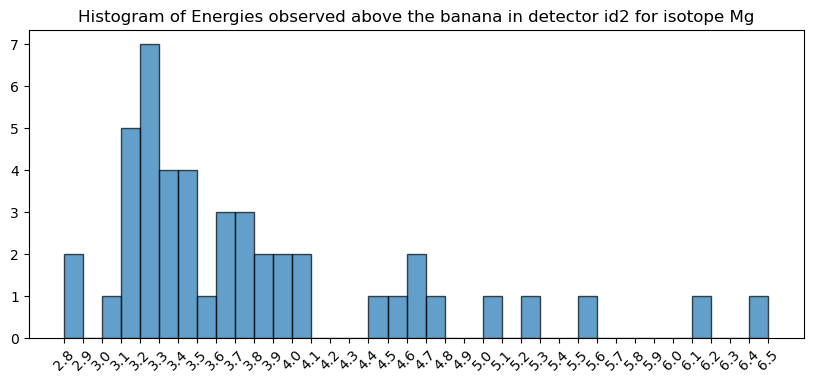

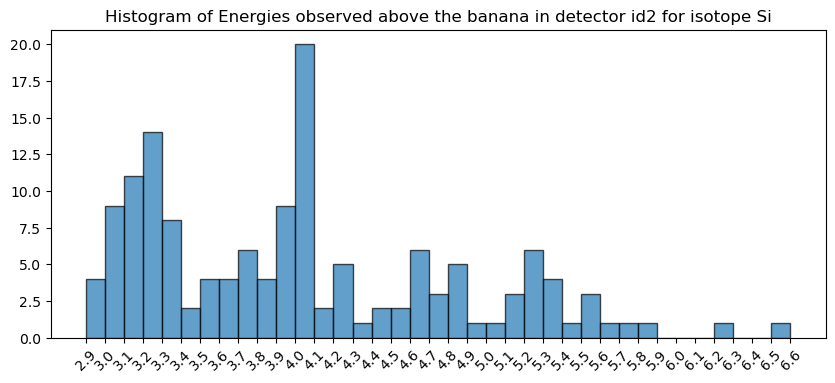

In [10]:
si_bedep = si_fedep = si_E = si_fi = si_bi = 0
p_bedep = p_fedep = p_E = p_fi = p_bi = 0
mg_bedep = mg_fedep = mg_E = mg_fi = mg_bi = 0
bedeps = [[[i] for i in range(4)] for _ in range(2)]
fedeps = [[[i] for i in range(4)] for _ in range(2)]
es = [[[i] for i in range(4)] for _ in range(2)]
fis = [[[i] for i in range(4)] for _ in range(2)]
bis = [[[i] for i in range(4)] for _ in range(2)]

for i in range(1,3):
    j = 0
    for k, _ in data_collection.items():
        if j==4:
            break
        polygon = np.column_stack((xs[i], ys[i]))
        polygon_path = Path(polygon)    
        points_ = np.column_stack((data_collection[k]["bEdep"][i], data_collection[k]["fEdep"][i]))
        mask_ = polygon_path.contains_points(points_)
        E_ = np.array(data_collection[k]["E"][i])[mask_]
        fedep_ = np.array(data_collection[k]["fEdep"][i])[mask_]
        bedep_ = np.array(data_collection[k]["bEdep"][i])[mask_]
        fi_ = np.array(data_collection[k]["FI"][i])[mask_]
        bi_ = np.array(data_collection[k]["BI"][i])[mask_]
        
        bedeps[i-1][j].append(bedep_)
        fedeps[i-1][j].append(fedep_)
        es[i-1][j].append(E_)
        fis[i-1][j].append(fi_)
        bis[i-1][j].append(bi_)
        
        j+=1
        
        rounded_E = np.round(E_,1)
        counts_ = Counter(rounded_E)    

        plt.figure(figsize=(10,4))
        plt.hist(rounded_E, bins=np.arange(min(rounded_E), max(rounded_E) + 0.1, 0.1), edgecolor="black", alpha=0.7)
        plt.xticks(np.arange(min(rounded_E), max(rounded_E) + 0.1, 0.1), rotation=45)
        plt.title(f"Histogram of Energies observed above the banana in detector id{i} for isotope {k}")


In [16]:
id1_regions = [(3.9,4.1), (4.5,4.7)] #for si & mg respectively
id2_regions = [(3.1,3.3), (3.2,3.4), (3.1,3.3)] # for si, P & Al respectively
len(bedeps[0][3])

2

Counts used to make linear fit for Si:  41
Counts used to make linear fit for Mg:  15
Counts used to make linear fit for Si:  29
Counts used to make linear fit for Al:  13
Counts used to make linear fit for P:  34


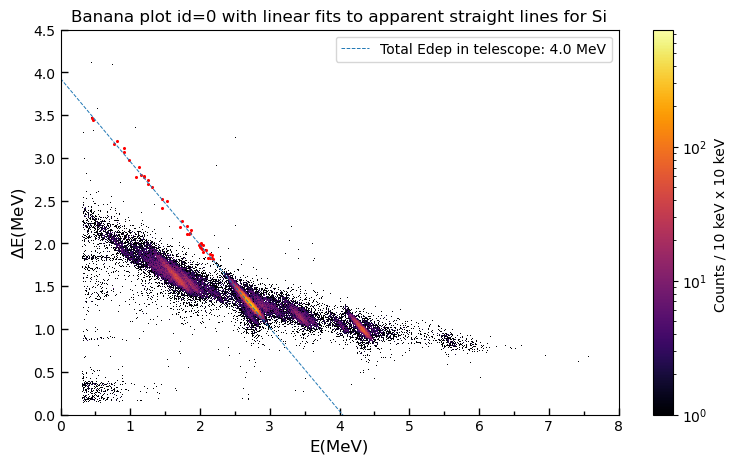

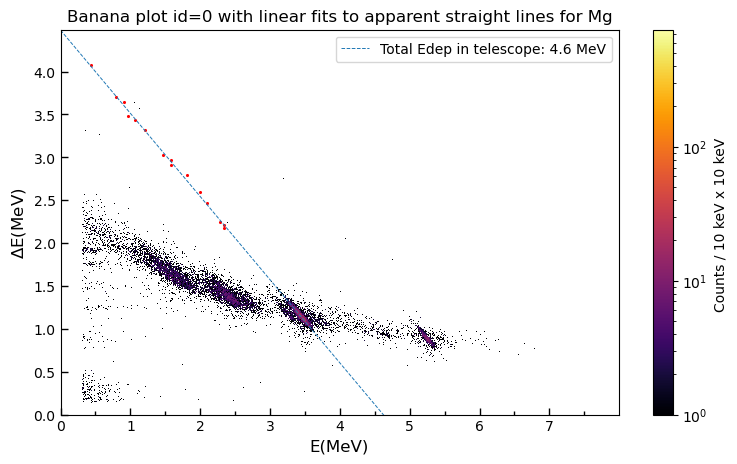

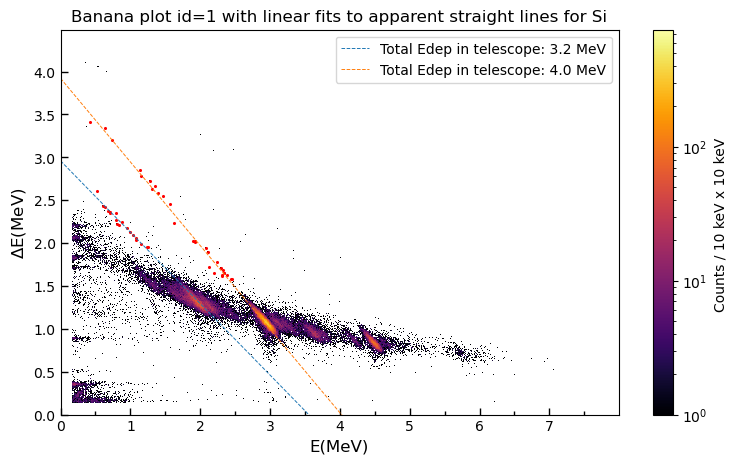

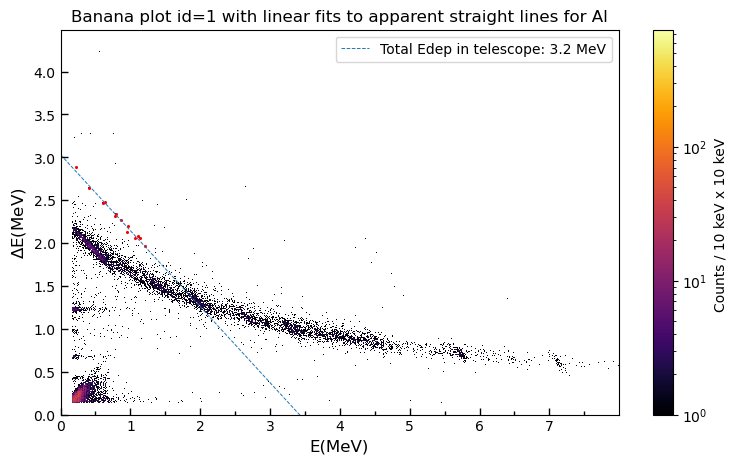

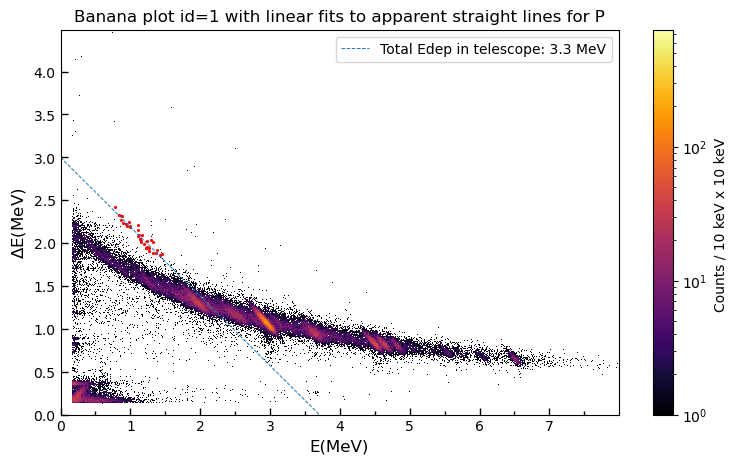

In [17]:
def linfunc(x, a, b):
    return a*x+b

id1_total_fi = []
id1_total_bi = []
id2_total_fi = []
id2_total_bi = []
###id1 
## Si id1
plt.figure(figsize=(9,5))
plt.hist2d(data_collection["Si"]["bEdep"][1], data_collection["Si"]["fEdep"][1], bins=(np.arange(0, 8, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

mask = (es[0][3][1]>=id1_regions[0][0]) & (es[0][3][1]<=id1_regions[0][1])
ef = fedeps[0][3][1][mask]
eb = bedeps[0][3][1][mask]
id1_total_fi.append(fis[0][3][1][mask])
id1_total_bi.append(bis[0][3][1][mask])
plt.scatter(eb,ef, marker='o', s=1.5, color='r')
popt, _ = sc.curve_fit(linfunc, eb, ef)
a, b = popt
fit_x = np.linspace(0, 6, 100)
fit_y = linfunc(fit_x, a, b)
plt.plot(fit_x,fit_y, ls='--', lw=0.7,
            label=f"Total Edep in telescope: {np.round((id1_regions[0][0]+id1_regions[0][1])/2, 2)} MeV")
plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.xlim(0, 8)
plt.ylim(0,4.5)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)
plt.title("Banana plot id=0 with linear fits to apparent straight lines for Si")
print("Counts used to make linear fit for Si: ",len(ef))
############################################################################################################
## Mg id1
plt.figure(figsize=(9,5))
plt.hist2d(data_collection["Mg"]["bEdep"][1], data_collection["Mg"]["fEdep"][1], bins=(np.arange(0, 8, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

mask = (es[0][2][1]>=id1_regions[1][0]) & (es[0][2][1]<=id1_regions[1][1])
ef = fedeps[0][2][1][mask]
eb = bedeps[0][2][1][mask]
id1_total_fi.append(fis[0][2][1][mask])
id1_total_bi.append(bis[0][2][1][mask])
plt.scatter(eb,ef, marker='o', s=1.5, color='r')
popt, _ = sc.curve_fit(linfunc, eb, ef)
a, b = popt
fit_x = np.linspace(0, 6, 100)
fit_y = linfunc(fit_x, a, b)
plt.plot(fit_x,fit_y, ls='--', lw=0.7,
            label=f"Total Edep in telescope: {np.round((id1_regions[1][0]+id1_regions[1][1])/2, 2)} MeV")
plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)
plt.title("Banana plot id=0 with linear fits to apparent straight lines for Mg")
print("Counts used to make linear fit for Mg: ",len(ef))
############################################################################################################
## Si id2
plt.figure(figsize=(9,5))
plt.hist2d(data_collection["Si"]["bEdep"][2], data_collection["Si"]["fEdep"][2], bins=(np.arange(0, 8, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
###################3
mask = (es[1][3][1]>=id2_regions[0][0]) & (es[1][3][1]<=id2_regions[0][1])
ef = fedeps[1][3][1][mask]
eb = bedeps[1][3][1][mask]
id2_total_fi.append(fis[1][3][1][mask])
id2_total_bi.append(bis[1][3][1][mask])
plt.scatter(eb,ef, marker='o', s=1.5, color='r')
popt, _ = sc.curve_fit(linfunc, eb, ef)
a, b = popt
fit_x = np.linspace(0, 6, 100)
fit_y = linfunc(fit_x, a, b)
plt.plot(fit_x,fit_y, ls='--', lw=0.7,
            label=f"Total Edep in telescope: {np.round((id2_regions[0][0]+id2_regions[0][1])/2, 2)} MeV")
####################
mask2 = (es[1][3][1]>=id1_regions[0][0]) & (es[1][3][1]<=id1_regions[0][1])
ef = fedeps[1][3][1][mask2]
eb = bedeps[1][3][1][mask2]
id2_total_fi.append(fis[1][3][1][mask])
id2_total_bi.append(bis[1][3][1][mask])
plt.scatter(eb,ef, marker='o', s=1.5, color='r')
popt, _ = sc.curve_fit(linfunc, eb, ef)
a, b = popt
fit_x = np.linspace(0, 6, 100)
fit_y = linfunc(fit_x, a, b)
plt.plot(fit_x,fit_y, ls='--', lw=0.7,
            label=f"Total Edep in telescope: {np.round((3.9+4.1)/2, 2)} MeV")
####################
plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)
plt.title("Banana plot id=1 with linear fits to apparent straight lines for Si")
print("Counts used to make linear fit for Si: ",len(ef))
############################################################################################################
## Al id2
plt.figure(figsize=(9,5))
plt.hist2d(data_collection["Al"]["bEdep"][2], data_collection["Al"]["fEdep"][2], bins=(np.arange(0, 8, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

mask = (es[1][0][1]>=id2_regions[2][0]) & (es[1][0][1]<=id2_regions[2][1])
ef = fedeps[1][0][1][mask]
eb = bedeps[1][0][1][mask]
id2_total_fi.append(fis[1][0][1][mask])
id2_total_bi.append(bis[1][0][1][mask])
plt.scatter(eb,ef, marker='o', s=1.5, color='r')
popt, _ = sc.curve_fit(linfunc, eb, ef)
a, b = popt
fit_x = np.linspace(0, 6, 100)
fit_y = linfunc(fit_x, a, b)
plt.plot(fit_x,fit_y, ls='--', lw=0.7,
            label=f"Total Edep in telescope: {np.round((id2_regions[2][0]+id2_regions[2][1])/2, 2)} MeV")
plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)
plt.title("Banana plot id=1 with linear fits to apparent straight lines for Al")
print("Counts used to make linear fit for Al: ",len(ef))
############################################################################################################
## P id2
plt.figure(figsize=(9,5))
plt.hist2d(data_collection["P"]["bEdep"][2], data_collection["P"]["fEdep"][2], bins=(np.arange(0, 8, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

mask = (es[1][1][1]>=id2_regions[1][0]) & (es[1][1][1]<=id2_regions[1][1])
ef = fedeps[1][1][1][mask]
eb = bedeps[1][1][1][mask]
id2_total_fi.append(fis[1][1][1][mask])
id2_total_bi.append(bis[1][1][1][mask])
plt.scatter(eb,ef, marker='o', s=1.5, color='r')
popt, _ = sc.curve_fit(linfunc, eb, ef)
a, b = popt
fit_x = np.linspace(0, 6, 100)
fit_y = linfunc(fit_x, a, b)
plt.plot(fit_x,fit_y, ls='--', lw=0.7,
            label=f"Total Edep in telescope: {np.round((id2_regions[1][0]+id2_regions[1][1])/2, 2)} MeV")
plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)
plt.title("Banana plot id=1 with linear fits to apparent straight lines for P")
print("Counts used to make linear fit for P: ",len(ef))
############################################################################################################

In [19]:
id1_total_bi = np.array(ak.flatten(id1_total_bi))
id1_total_fi = np.array(ak.flatten(id1_total_fi))
id2_total_bi = np.array(ak.flatten(id2_total_bi))
id2_total_fi = np.array(ak.flatten(id2_total_fi))

Text(0, 0.5, 'Back index')

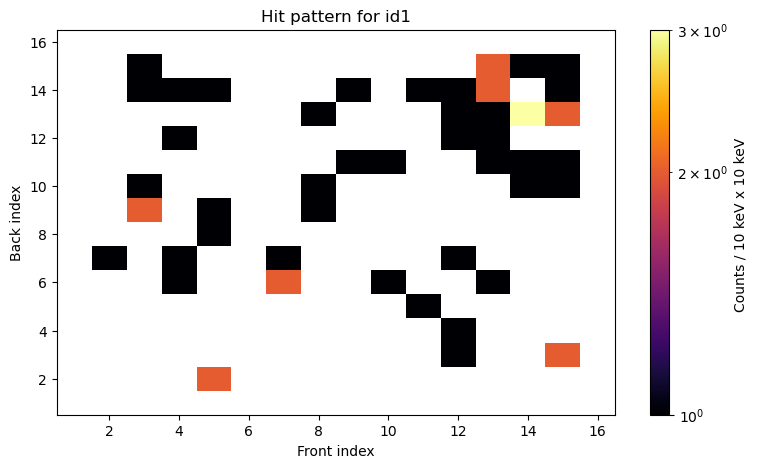

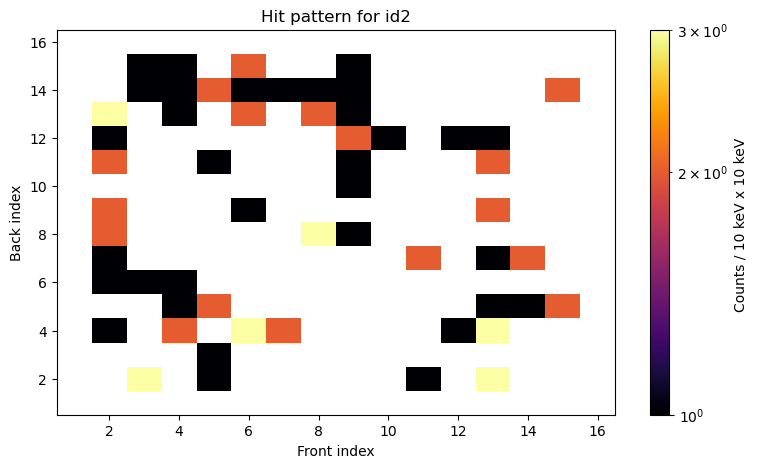

In [20]:
##Total hitpatterns
plt.figure(figsize=(9,5))
plt.hist2d(id1_total_fi-0.5, id1_total_bi-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=3), rasterized=True)
plt.title(f"Hit pattern for id1")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')

plt.figure(figsize=(9,5))
plt.hist2d(id2_total_fi-0.5, id2_total_bi-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=3), rasterized=True)
plt.title(f"Hit pattern for id2")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')